# Домашняя работа 6. Классификация.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.
4. Пришлите на почту ml-teachers ссылку на этот файл в вашем репозитории.
5. В теме письма указать `ML Homework #6: Name Surname`. Если тема будет неправильная, то задание не будет проверено.

**Дедлайн**: 4.12.2017 01:00 OMSK

    После дедлайна можно сдать, но вы получите штраф по баллам в рейтинге.

**Рассылка решений**: 9.12.2017 17:00 OMSK

    После рассылки задания совсем не имеют веса.

### Полезная литература

- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Коллаборативная фильтрация - рекомендательная система](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F)
- [Метрики расстояний - косинусная, минковского, проклятье размерности ](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf)
- [Offtop: метрики качества рекомендаьельных систем](https://habrahabr.ru/company/dca/blog/281066/)
- [Байесовский классификатор](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80)
- [Интересная статья про спам/не спам](https://habrahabr.ru/post/252265/)

Если вам понравилась задача распознавания текстов, то вот подборочка:

- [библиотека Gensim](https://radimrehurek.com/gensim/)
- [библиотека nltk](http://www.nltk.org/)
- [Лекция про word2vec 🔥](https://www.youtube.com/watch?v=oBb9aFmp0Hs)
- [Лекция Векторные представления слов и документов 🔥](https://www.youtube.com/watch?v=hiDBnEyoZS4)

В этой практике мы будем использовать алгоритмы k ближайших соседей и наивный байес для задач классификации и не только. 

## kNN - ближайшие соседи

Мы уже видели с вами на практиках и лекциях как применять алгоритм ближайших соседей. Мы даже видели с вами на примере классификации sms-спама, что этот метрический алгоритм не всегда справляется с многомерными данными. Поэтому в домашнем задании мы с вами сконцентриуемся на другой задаче, котоую можно решить этим алгоритмом: вы построите рекомендательную систему.

### Рекомендательная система

Будем использовать известный нам [датасет с оценками фильмов](http://www.cs.umn.edu/GroupLens). Только в этот раз мы не будем кластеризовывать жанры, а будем рекомендовать похожие фильмы, основываясь на оценках других пользователей. То есть мы будем по факту предсказывать предпочтение нового пользователя на основе других.

Для рекомендательной системы в датасете в объектами будут пользователи, а признаками - оценки фильма данным пользователем.

![](https://i.imgur.com/hn3xjZl.png)

Мы будем использовать метрический алгоритм для поиска ближайших соседей, тем самым рекомендовать фильмы близкие к данному.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
movies = pd.read_csv('data/imdb_movies.csv.gz', index_col='movieId')
ratings = pd.read_csv('data/imdb_ratings.csv.gz')

print(movies.shape)
print(ratings.shape)

(9125, 2)
(100004, 4)


In [3]:
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


### 1.1 Поиск популярных фильмов (3 балла)

Среди всех фильмов есть не популярные, для которых выставлена 1-2 оценки. Такого количества данных не достаточно, поэтому нужно срезать много фильмов с маленьким числом отзывов.

Посчтитайте количество оценок для каждого фильма.

In [5]:
number_values = pd.DataFrame(ratings.groupby('movieId')['userId'].agg(np.size))
number_values.head()

,userId
movieId,
1,247
2,107
3,59
4,13
5,56


Выведите сводную статистику по количеству оценок фильмов. (общее число фильмов, среднее количество оценок, дисперсию, квантили)

In [6]:
number_values.describe()

,userId
count,9066.000000
mean,11.030664
std,24.050800
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,341.000000


Как мы видим `75%` квантиль показывет, что `75%` фильмов имело очень мало оценок. Нам столько будет недостаточно. Посчтитайте квантили в диапазоне от `75%` до `100%` с шагом в `1%`. Выберите тот квантиль, при котором количество оценок равно 20. Напишите какой это квантиль. Напишите сколько всего фильмов останется, если отбросить все фильмы у которых рейтинг меньше этого квантиля.

In [7]:
describe = pd.DataFrame(number_values.describe(percentiles = [i/100 for i in range(75, 100)]))
print(describe[describe['userId']==20.])
numb_val = number_values[number_values['userId']>=20.]
print(numb_val.shape[0], 'фильмов имеют не менее 20 отзывов')

     userId
86%    20.0
1303 фильмов имеют не менее 20 отзывов


### 1.2 Соединяем таблицы (1 балл)

Будет немного не удобно искать фильмы по их идентификаторам, нам нужны названия. Поэтому соедините две таблицы `ratings` и `movies` по `movieId` и отфильтруйте отзывы на редкие фильмы, которые мы нашли в предыдущем шаге. Выведите первые 5 элементов полученного датасета.

In [8]:
merge = ratings.merge(movies,'left', left_on='movieId', right_index=True)
rat_mov = merge[merge['movieId'].isin(numb_val.index.tolist())]
rat_mov.head()

,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama


### 1.3 Матрица Фильмы-Пользователи

В нашем случае мы будем искать похожие фильмы, поэтому сделайте из датасета оценок матрицу, где в строках фильмы, в колонках пользователи, а в ячейках оценки. Пропущенные значение, то есть отсутсвие оценки, заполните 0.

Для увеличения скорости выполнения алгоритма ближайших соседей примените функцию [`scipy.sparse.csc_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html),  которая создаст плотное представление нашей разреженой матрицы.

In [30]:
from scipy.sparse import csr_matrix
row = rat_mov['movieId']
col = rat_mov['userId']
data = rat_mov['rating']
df = csr_matrix((data, (row, col)))
df

<134854x672 sparse matrix of type '<class 'numpy.float64'>'
	with 69104 stored elements in Compressed Sparse Row format>

### 1.4 Тренировка модели рекомендаций 

Так как по сути у нас нет каких-то меток классов, мы будем использовать алгоритма без учителя [`sklearn.neighbors.NearestNeighbors`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html). Научите его по данным нашей матрицы пользователей-фильмов и напишите **функцию**, принимающую на вход название фильма и возвращающую список из 6 рекомендованых фильмов, начиная от более похожего.

Для определения "похожести" двух фильмов мы будем использовать косинусную меру, вместо евклидова или минковского:

$$\LARGE cos(\overrightarrow{x},\overrightarrow{y}) = \frac{\overrightarrow{x} \cdot \overrightarrow{y}}{||\overrightarrow{x}|| \times ||\overrightarrow{y}||}$$

In [31]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(6, metric='cosine', n_jobs=-1)
neigh.fit(df)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=6, p=2, radius=1.0)

In [33]:
def similar(name, n):
    idx = movies[movies['title']==name].index[0]
    ind = neigh.kneighbors(df[idx:idx+1], n+1, return_distance=False)
    for i in ind[0][1:]:   
        print(list(movies[movies.index==i]['title'])[0])

Выведите рекомендации для фильмов:
- `Pulp Fiction (1994)`
- `Star Wars: Episode V - The Empire Strikes Back (1980)`
- `Lord of the Rings: The Two Towers, The (2002)`

In [34]:
similar('Pulp Fiction (1994)', 6)

Silence of the Lambs, The (1991)
Shawshank Redemption, The (1994)
Seven (a.k.a. Se7en) (1995)
Forrest Gump (1994)
Usual Suspects, The (1995)
Jurassic Park (1993)


In [35]:
similar('Star Wars: Episode V - The Empire Strikes Back (1980)', 6)

Star Wars: Episode IV - A New Hope (1977)
Star Wars: Episode VI - Return of the Jedi (1983)
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Indiana Jones and the Last Crusade (1989)
Back to the Future (1985)
Terminator, The (1984)


In [36]:
similar('Lord of the Rings: The Two Towers, The (2002)', 6)

Lord of the Rings: The Return of the King, The (2003)
Lord of the Rings: The Fellowship of the Ring, The (2001)
Pirates of the Caribbean: The Curse of the Black Pearl (2003)
Matrix, The (1999)
Spider-Man (2002)
Shrek (2001)


### 1.5 Как посчитать качество рекомендации?

Как посчитать качество нашей классификации? У нас нет учителя, нет отложенной выборки. Мы просто посчитали все рейтинги и на основе них сделали предположения о похожести товаров. 

А как вы думаете можно проверить качество нашей рекомендательной системы? Напишите развернутый ответ своими словами.

Нужно разделить выборку на тренировочную и тестовую. Тренировочную использовать для обучения, а тестовую для оценки качества с помощью различных метрик. Например, можно по каждому пользователю часть оценок отправить в тестовый набор. Затем, для одного фильма из тестового набора пользователя получить рекомендованый список и сравнить его с тестовым списком этого пользователя. Чем больше будет совпадений, тем лучше система рекомендует то, что пользователю действительно было интересно.

## Наивный байесовский классификатор

На практике мы использовали его для детекции спам/не спам. В этот раз вы будете классифицировать [новостные тексты](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html). Попробуете разные методы  генерации признаков из текстов.

In [37]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 2.1 Загрузка данных (2 балла)

Мы будем использовать только 4 класса текстов: `'alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics'`.

Загрузите тренировочную и тестовую части датасета для этих категорий.

In [38]:
cats = ['alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics']
newsgroups_train_ = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=cats)
print("%d documents" % len(newsgroups_train_.filenames))
print("%d categories" % len(newsgroups_train_.target_names))

2034 documents
4 categories


In [39]:
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=cats)
print("%d documents" % len(newsgroups_test.filenames))
print("%d categories" % len(newsgroups_test.target_names))

1353 documents
4 categories


Выведите по 1 тексту для каждой из категории.

In [40]:
for cat in cats :
    data = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=[cat]).data
    print(cat, data[1])
    print()

alt.atheism 

I would rather be at a higher risk of being killed than actually killed by
                              ^^^^                      ^^^^^^^^
mistake.  Though I do agree with the concept that the type D and E murderers
are a massive waste of space and resources I don't agree with the concept:

	killing is wrong
	if you kill we will punish you
	our punishment will be to kill you.

Seems to be lacking in consistency.


sci.space 
Glad to see Griffin is spending his time on engineering rather than on
ritual purification of the language.  Pity he got stuck with the turkey
rather than one of the sensible options.

talk.religion.misc 
You're admitting a lot more than that.  You are admitting that
your morals are situational.   You are admitting that the actions
of other people and the situation you are in help to determine
how you judge the moral significance of one of your own actions.

If you employ X degree of force, that's not moral, but if you employ
X degree of force, but p

### 2.2 Мешок слов

Начнем с самого простого способа извлечения признаков из текстов: обычный подсчет количества употреблений слов в тексте.

Для этого используем [sklearn.feature_extraction.text.CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Настройте его так, чтобы он использовал англиские стоп слова.

Проведите трансформаци текстов из обоих датасетов и выведите размер полученного словаря. (1 векторайзер для тестового и тренировочного датасета! У вас должны получиться матрицы с одинаковыми признаками-словами)

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
print('stop_words', len(vectorizer.get_stop_words()))
      
X_train = vectorizer.fit_transform(newsgroups_train_.data)
print(X_train.shape)
train_vocabulary = vectorizer.vocabulary_
print('train vocabulary', len(train_vocabulary))

X_test = vectorizer.transform(newsgroups_test.data)
print(X_test.shape)
test_vocabulary = vectorizer.vocabulary_
print('test vocabulary', len(test_vocabulary))

stop_words 318
(2034, 26576)
train vocabulary 26576
(1353, 26576)
test vocabulary 26576


Будем использовать классифиактор для мультиклассифкации [sklearn.naive_bayes.MultinomialNB]().

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [52]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

print(cross_val_score(MultinomialNB(alpha=0.01), X_train, newsgroups_train_.target, cv=5 ,scoring='accuracy').mean())

clf = MultinomialNB(alpha=0.01)
clf.fit(X_train, newsgroups_train_.target)

y_pred = clf.predict(X_test)

0.826949442879


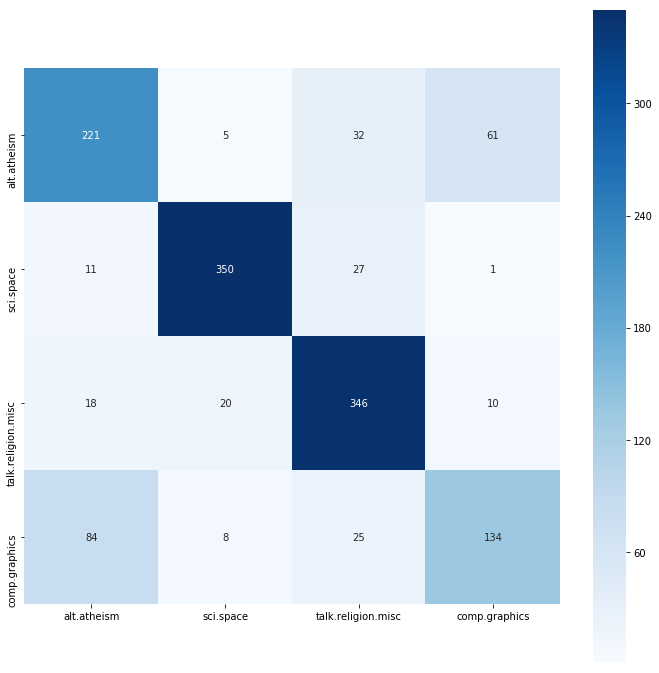

In [53]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(newsgroups_test.target, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.3g', 
            xticklabels=cats, yticklabels=cats)

In [54]:
from sklearn.metrics import classification_report
print(classification_report(newsgroups_test.target, y_pred))

             precision    recall  f1-score   support

          0       0.66      0.69      0.68       319
          1       0.91      0.90      0.91       389
          2       0.80      0.88      0.84       394
          3       0.65      0.53      0.59       251

avg / total       0.77      0.78      0.77      1353



In [55]:
# Посмотрим на ТОП 10 по важности слова в каждой категории

def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: [%s]" % (category, " ".join(feature_names[top10])))

show_top10(clf, vectorizer, newsgroups_train_.target_names)

alt.atheism: [like believe say atheism does just think don people god]
comp.graphics: [software images files data use file jpeg edu graphics image]
sci.space: [just shuttle time orbit data like earth launch nasa space]
talk.religion.misc: [know say christian think just bible don jesus people god]


### 2.3 [Tf-IDF](https://ru.wikipedia.org/wiki/TF-IDF)

Мешок слов не учитывает "веса" слов, он просто смотрит их вхождение в документ. Вероятно, было бы полезно взвесить каким-то обраом каждое слово в документе. Действительно, если слово встречается во всех документах, то, наверное, его вес небольшой. А если редкое слово встречается в некоторых документах, то скорее всего оно какое-то узко тематическое.

Один из способов взвесить слова - это использовать меру tf-idf, где:

**TF - term frequency** - частота слова для каждой статьи

$$\LARGE \mathrm{tf}(t,d) = \frac{n_t}{\sum_k n_k}$$

**IDF - inverse document frequency*** — обратная частота документа - уменьшает вес часто встречаемых слов

$$\LARGE \mathrm{idf}(t, D) =  \log \frac{|D|}{|\{\,d_i \in D \mid t \in d_{i}\, \}|}$$

$D$ - число документов в корпусе

$|\{\,d_i \in D \mid t \in d_{i}\, \}|$ - число документов из коллекции ${\displaystyle D}$ , в которых встречается ${\displaystyle t}$  (когда ${\displaystyle n_{t}\neq 0}$ ).

**TF-IDF**

$$\LARGE \operatorname{tf-idf}(t,d,D) = \operatorname{tf}(t,d) \times \operatorname{idf}(t, D)$$


Для него есть класс [sklearn.feature_extraction.text.TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer 

vectorizer = TfidfVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train_.data)
vectors.shape
print('stop_words', len(vectorizer.get_stop_words()))
      
X_train = vectorizer.fit_transform(newsgroups_train_.data)
print(X_train.shape)
train_vocabulary = vectorizer.vocabulary_
print('train vocabulary', len(train_vocabulary))

X_test = vectorizer.transform(newsgroups_test.data)
print(X_test.shape)
test_vocabulary = vectorizer.vocabulary_
print('test vocabulary', len(test_vocabulary))

stop_words 318
(2034, 26576)
train vocabulary 26576
(1353, 26576)
test vocabulary 26576


In [57]:
print(cross_val_score(MultinomialNB(alpha=0.01), X_train, newsgroups_train_.target, cv=5 ,scoring='accuracy').mean())

clf = MultinomialNB(alpha=0.05)
clf.fit(X_train, newsgroups_train_.target)

y_pred = clf.predict(X_test)

0.851036771297


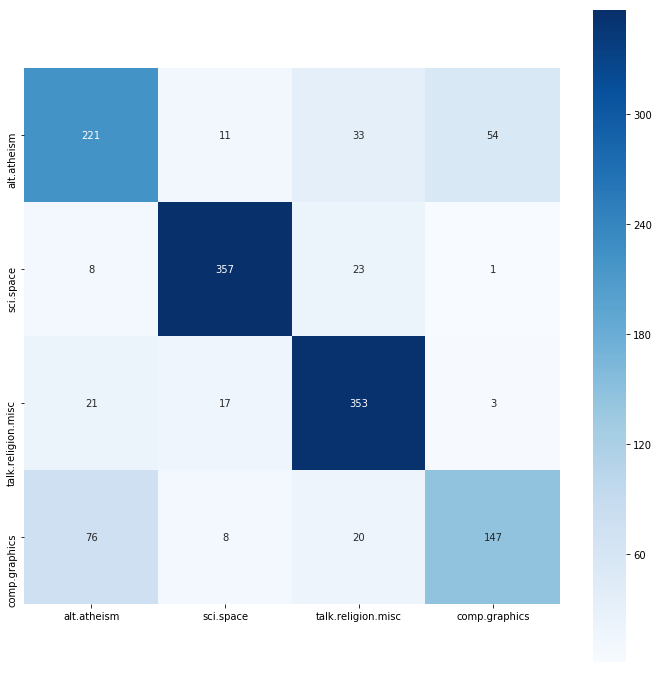

In [58]:
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(newsgroups_test.target, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.3g', 
            xticklabels=cats, yticklabels=cats)

In [59]:
print(classification_report(newsgroups_test.target, y_pred))

             precision    recall  f1-score   support

          0       0.68      0.69      0.69       319
          1       0.91      0.92      0.91       389
          2       0.82      0.90      0.86       394
          3       0.72      0.59      0.64       251

avg / total       0.79      0.80      0.79      1353



In [60]:
show_top10(clf, vectorizer, newsgroups_train_.target_names)

alt.atheism: [islam does religion atheism say just think don people god]
comp.graphics: [windows does looking program know file image files thanks graphics]
sci.space: [earth think shuttle orbit moon just launch like nasa space]
talk.religion.misc: [objective think just bible don christians christian people jesus god]


### 2.4 В чём проблема?

Как вы заметили, качество немного улучшилось. Как вы думаете почему у нас до сих пор есть ошибки? В чём проблема? Опирайтесь на вывод топа 10 важных слов, confusion matrix и репорт классификации.

**Задание**: Напишите развернутое рассуждение.

Ответ:  Возможно классы не сбалансированы? У классов с большим количеством объектов выше значения точности, полноты и f-меры. В каждой группе важных слов tf-idf появилось в начале по 2-3 новых слова, которых не было в "мешке слов", но остальные слова по большей части такие же. Видимо взвешивание слов на этих данных не сильно улучшает качество. Это видно и по confusion matrix: для tf-idf единичные улучшения (от 7 до 13) по главной диагонали для трех последних классов,  характер распределения значений в остальных клетках приблизительно такой же, как и в "мешке". 

Среди важных слов в группах про атеизм и религию есть одинаковые, это не удивительно, поскольку обе группы по сути об одном и том же - о боге, просто смысловое значение их тестов диаметрально противоположное. Но ни мешок слов, ни tf-idf не учитывают контекста, поэтому, наверное, в обоих случаях векторизации будут присутствовать ошибки и качество классификации не очень различается. Кроме этого, как в мешке, так и в tf-idf, среди важных слов про компьютерную графику есть как единственное, так и множественное число одних и тех же слов (file, image), т.е. они соответствуют различным признакам. Наверно, это не оптимальный подход, и тоже не способствует улучшению качества классификации.

![](https://i.imgur.com/3D5pgrk.png)

Можно еще немного улучшить качество предсказания, если использовть n-граммы, то есть не только одиночные слова, но и пары, тройки. Для этого у векторайзера есть параметр `ngram_range`, но будьте осторожны, сгенерируется очень много признаков. Их количество можно ограничить  `max_features`. Ещё можно копать в сторону правильного процессинга текстов: лемматизация и стемминг, чтобы убирать окончания, но это обчно не сильно помогает в английском языке.

Кроме того можно было бы пойти совсем в другую сторону и использовать word-2-vec технологии, тогда бы у нас слова начал "обретать" смысл. Но это вовсем другая история.